# **Linking OS APIs to EPC API**

In this tutorial, we will learn how to use multiple OS APIs to acquire addresses within a specific postcode and use their UPRN to acquire their building footprint, alongside acquiring their Energy Performance Certificate (EPC) rating using the EPC Domestic Rates API and visualise this data on a map.

# What APIs are used?
- OS Places API
- OS Linked Identifiers API
- OS NGD Features API
- OS Maps API
- EPC Domestic Rates API

# What's needed?
- A valid OS Premium API Key
- A Valid EPC Domestic Rates API Key (Use encripted API Key for this tutorial)

<br><br>

**Disclaimers:** 
- Please note that OS API throttling may cause errors in this notebook. To avoid these errors, then specify a postal code with less 600 or less addresses (unless you have different access). For further information on OS API throttling please visit [here](https://osdatahub.os.uk/support/plans#apiThrottling).
<br>
- This is for domestic rates only; therefore commercial property EPC ratings will not be returned.

# How it works:
![Flow Chart of Notebook.png](<attachment:Flow Chart of Notebook.png>)
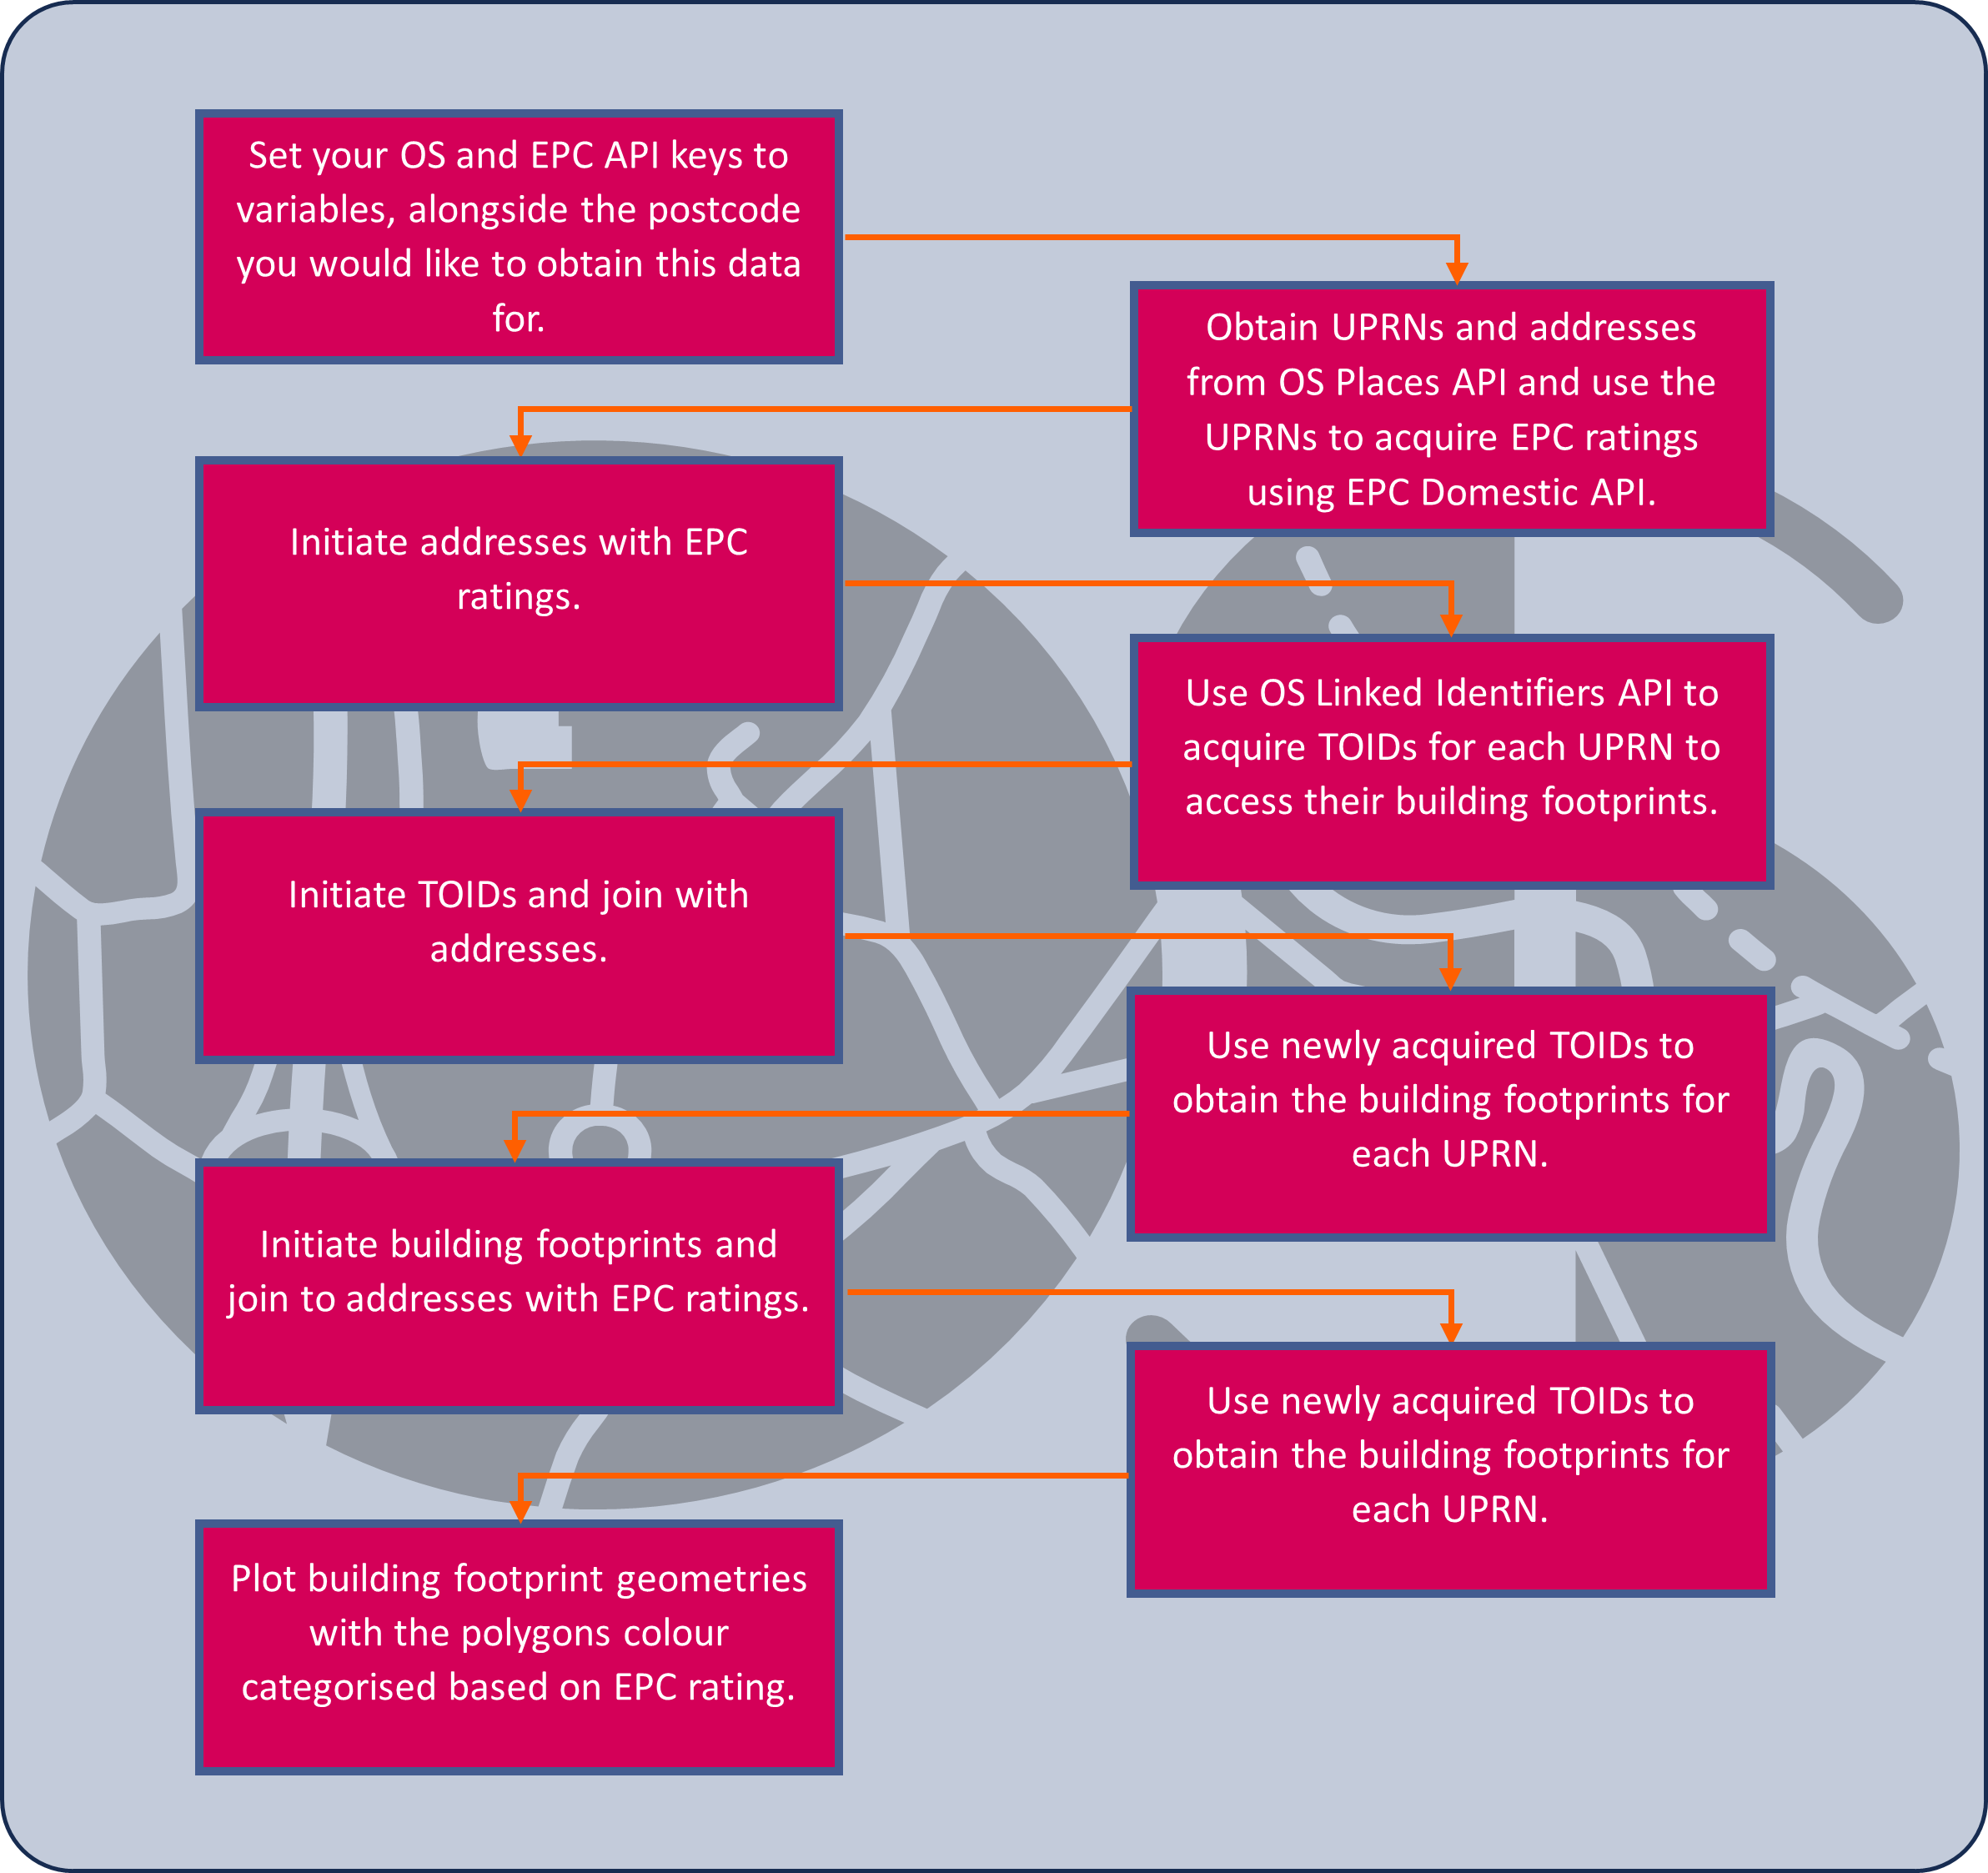

In [7]:
# Imports - If you don't have any of these packages installed, then simply add a cell above this one and use pip install {package_name}
import json as j 
import geopandas as gpd
import pandas as pd
import requests as r 
import time
import warnings
import os
import folium
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')

In [2]:
# Settings 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# API Keys and Postcode

Set API keys and desired postcode as variables, allowing ease of use and 'Run All' once populated.

In [3]:
# OS API Key
os_key = ''

# EPC API Key
epc_key = r""

# Desired Postcode
desired_postcode = ''

# Linking OS PLaces API to EPC API

Acquire the EPC ratings for specified postcode via EPC API and joining to OS Places API to verify the UPRN
for each feature.


***Disclaimer:*** *This will return multiple values for some results as historical epc ratings are included. Optional code in definition below to only return the most recent epc rating.*

In [4]:
def epc_places(postcode, os_apikey, epc_apikey):
    # OS places request
    places_header_response = r.get(f'https://api.os.uk/search/places/v1/postcode?postcode={postcode}&key={os_apikey}').json()
    # Initialise offset going in steps of 100 (page size)
    offset = range(0,places_header_response['header']['totalresults'],100)
    # Initialise empty places dataframe
    result_places=pd.DataFrame()

    # Iterating through offset and joining each iteration into places dataframe
    for n in offset:
        places_url=f'https://api.os.uk/search/places/v1/postcode?postcode={postcode}&offset={n}&key={os_apikey}'
        response = r.get(places_url).json()
        normalised = pd.json_normalize(response['results'])
        result_places = pd.concat([result_places,normalised])
        n=n+1

    # Initialising EPC headers and parameters
    headers_epc = {
    'Authorization': f'Basic {epc_apikey}',
    'Accept' : 'application/json'
    }

    params_epc = {
        'postcode': postcode,
        'size': 10000
    } 
    # Acquiring all EPC data for specified postcode
    epc_url = r"https://epc.opendatacommunities.org/api/v1/domestic/search"
    epc_response = r.get(epc_url, headers=headers_epc, params=params_epc).json()
    epc_data = pd.json_normalize(epc_response['rows'])

    # Join places results to EPC results on UPRN
    result = pd.merge(result_places.assign(x=result_places['DPA.UPRN'].astype(str)),
                        epc_data.assign(x=epc_data['uprn'].astype(str)), 
                        on='x', how='left')
    
    # Clean up results dataframe
    result.drop(columns=['uprn', 'address'], inplace=True)
    result.rename(columns={'DPA.UPRN':'uprn', 'DPA.ADDRESS':'address'}, inplace=True)
   
    # EPC API sometimes returns duplicate rows where the data is exactly the same, below drops duplicates based on Address and the date it was inspected, if the date's the same, it'll remove one instance.
    result.drop_duplicates(subset=['address', 'inspection-date'], inplace=True)
    
    # Include below for most recent epc rating only.
    # result.drop_duplicates('uprn', inplace=True)

    # Return what is needed from result
    return result[['uprn','address','current-energy-rating', 'inspection-date']]


In [ ]:
# Initiate Addresses with EPC ratings
address_epc = epc_places(desired_postcode, os_key, epc_key)

# OS Linked Identifiers API

Using Linked Identifiers to obtain Toids for each feature to enable the abiltiy to obtain building parts for each feature

In [ ]:
# get toids from epc table UPRNs
def get_toid(uprn_column, os_apikey):

    # Initiate final dataframe
    result_li = pd.DataFrame()

    # Iterate through all UPRNs in UPRN column and concatto final dataframe
    for uprn in uprn_column:
        identifierType='UPRN'
        identifiers_url = f'https://api.os.uk/search/links/v1/identifierTypes/{identifierType}/{uprn}?key={os_apikey}'
        linked_ids = r.get(identifiers_url).json()
        linked_ids = pd.json_normalize(linked_ids['correlations'])
        # Ensure UPRN is present in new dataframe to link back to
        linked_ids['uprn'] = uprn
        result_li = pd.concat([result_li, linked_ids])
        
    # Only get topographic areas and get the toid identifier
    result_li = result_li[result_li['correlatedFeatureType']=='TopographicArea']
    result_li = result_li.explode('correlatedIdentifiers')
    result_li['toid'] = result_li['correlatedIdentifiers'].apply(lambda x: x.get('identifier', None))
    return result_li

In [ ]:
# Initiate toids
toids = get_toid(address_epc['uprn'].unique(), os_key)

In [ ]:
# Merge toids to epc addresses and clean up dataframe
epc_address_with_toids = pd.merge(address_epc, toids, on='uprn', how='inner')
epc_address_with_toids = epc_address_with_toids.drop(['searchedIdentifierVersionDate', 'correlationMethodIdentifier', 'correlatedIdentifierType', 'correlatedIdentifiers' ], axis=1)

# Attach to OS NGD Features API 

Attach OS NGD Features API (building parts) to addresses with epc ratings

In [ ]:
def get_building_parts(toid_column, os_apikey):

    # Initiate empty building parts dataframe
    building_part = gpd.GeoDataFrame()

    # Iterate through toids in toid column
    for toid in toid_column:
        features = r.get(f"https://api.os.uk/features/ngd/ofa/v1/collections/bld-fts-buildingpart-1/items?filter=toid%20=%20'{toid}'&key={os_apikey}").json()
        features_gdf = gpd.GeoDataFrame.from_features(features['features'])
        building_part = pd.concat([building_part, features_gdf])

    # Clean up dataframe
    building_part = building_part[['osid','toid','geometry']]
    
    return building_part

In [ ]:
# Initate building parts
building_parts = get_building_parts(epc_address_with_toids['toid'].unique(), os_key)

# Data Collation

Merge building parts with addresses with EPC ratings to get final dataset as a geopandas dataframe

In [ ]:
epc_building = pd.merge(building_parts, epc_address_with_toids, on='toid', how='right')

# Final dataframe, reorganisation of dataframe and set crs
epc_building = epc_building[['osid','uprn','toid','address','current-energy-rating','inspection-date','geometry']].set_crs(crs=4326)
epc_building

# Plot on a Map

Plot the buildings data on a map with a colour code and legend for its rating, using OS maps layers.

In [ ]:
# Fixed colour map for EPC ratings
epc_colours = {
    'A': '#32CD32',  # Green
    'B': '#00FF00',  # Lime Green
    'C': '#FFFF00',  # Yellow
    'D': '#FFD700',  # Light Orange
    'E': '#FFA500',  # Orange
    'F': '#FF6347',  # Light Red
    'G': '#FF0000',  # Red
    None:'#A9A9A9'   # Dark Gray for NaN values
}

# 
epc_building['cmap_colour']=epc_building['current-energy-rating'].map(epc_colours)

# Create colour map
colour_map = ListedColormap([epc_colours[rating] for rating in sorted(epc_colours.keys(), key=lambda x: (x is None, x))])

In [ ]:
epc_map = epc_building.explore("current-energy-rating", 
                cmap = colour_map,
                tiles = 'https://api.os.uk/maps/raster/v1/zxy/Light_3857/{z}/{x}/{y}.png?key=', # Insert OS API Key to URL as the structure of the URL doesn't allow for an f-string
                attr = 'OS',)

epc_map

# Save map as a HTML file

Uncomment if you would like to save the above map as a file.

In [ ]:
save_directory = r""
epc_map.save(f"{save_directory}\epc_map.html")